# Data Preprocessing Pipeline

This notebook loads and preprocesses toxic comment datasets for safety filter training.

## 1. Setup

In [3]:
import pandas as pd
import numpy as np
from pathlib import Path

DATA_DIR = Path("/Users/ar.babkin/Desktop/Visual_Studio_IDE/GenAI-Safety-Fliter/data/original")

## 2. Load Datasets

In [4]:
# Load Jigsaw dataset (multilabel -> binary)
jigsaw = pd.read_csv(DATA_DIR / 'jigsaw_train.csv')

# Any toxic label = 1, otherwise 0
toxic_cols = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
jigsaw['y'] = (jigsaw[toxic_cols].sum(axis=1) > 0).astype(int)

jigsaw_clean = pd.DataFrame({
    'source': 'jigsaw',
    'text': jigsaw['comment_text'],
    'y': jigsaw['y']
})

print(f"Jigsaw: {len(jigsaw_clean)} samples, {jigsaw_clean['y'].mean():.2%} toxic")

Jigsaw: 159571 samples, 10.17% toxic


In [5]:
# Load Russian Language Toxic Comments (binary)
russian_toxic = pd.read_csv(DATA_DIR / 'blackmoon_train.csv')

russian_toxic_clean = pd.DataFrame({
    'source': 'russian_toxic',
    'text': russian_toxic['comment'],
    'y': russian_toxic['toxic'].astype(int)
})

print(f"Russian Toxic: {len(russian_toxic_clean)} samples, {russian_toxic_clean['y'].mean():.2%} toxic")

Russian Toxic: 14412 samples, 33.49% toxic


In [6]:
# Load Combined Hate Speech Dataset (binary)
hate_speech = pd.read_csv(DATA_DIR / 'mahmoudabusaqer_train.csv')

hate_speech_clean = pd.DataFrame({
    'source': 'hate_speech',
    'text': hate_speech['text'],
    'y': hate_speech['class'].astype(int)
})

print(f"Hate Speech: {len(hate_speech_clean)} samples, {hate_speech_clean['y'].mean():.2%} toxic")

Hate Speech: 48049 samples, 57.78% toxic


In [7]:
# Load Toxic Russian Comments (fasttext format -> binary)
with open(DATA_DIR / 'alexandersemiletov_train.txt', 'r', encoding='utf-8') as f:
    lines = f.readlines()

toxic_russian_data = []
for line in lines:
    line = line.strip()
    if not line:
        continue
    
    # Parse fasttext format: __label__XXX text
    if line.startswith('__label__'):
        parts = line.split(' ', 1)
        if len(parts) == 2:
            label = parts[0].replace('__label__', '')
            text = parts[1]
            
            # NORMAL = 0, anything else = 1
            y = 0 if label == 'NORMAL' else 1
            toxic_russian_data.append({'text': text, 'y': y})

toxic_russian_clean = pd.DataFrame(toxic_russian_data)
toxic_russian_clean['source'] = 'toxic_russian'
toxic_russian_clean = toxic_russian_clean[['source', 'text', 'y']]

print(f"Toxic Russian: {len(toxic_russian_clean)} samples, {toxic_russian_clean['y'].mean():.2%} toxic")

Toxic Russian: 248290 samples, 17.96% toxic


## 3. Concatenate Datasets

In [8]:
# Concatenate all datasets
df_all = pd.concat([
    jigsaw_clean,
    russian_toxic_clean,
    toxic_russian_clean,
    hate_speech_clean
], ignore_index=True)

# Remove missing values
df_all = df_all.dropna(subset=['text', 'y'])

print(f"Total: {len(df_all)} samples")
print(f"Overall toxicity rate: {df_all['y'].mean():.2%}")
print(f"\nDistribution by source:")
print(df_all.groupby('source')['y'].agg(['count', 'mean']))

Total: 470322 samples
Overall toxicity rate: 19.86%

Distribution by source:
                count      mean
source                         
hate_speech     48049  0.577764
jigsaw         159571  0.101679
russian_toxic   14412  0.334860
toxic_russian  248290  0.179649


## 4. Data Analysis

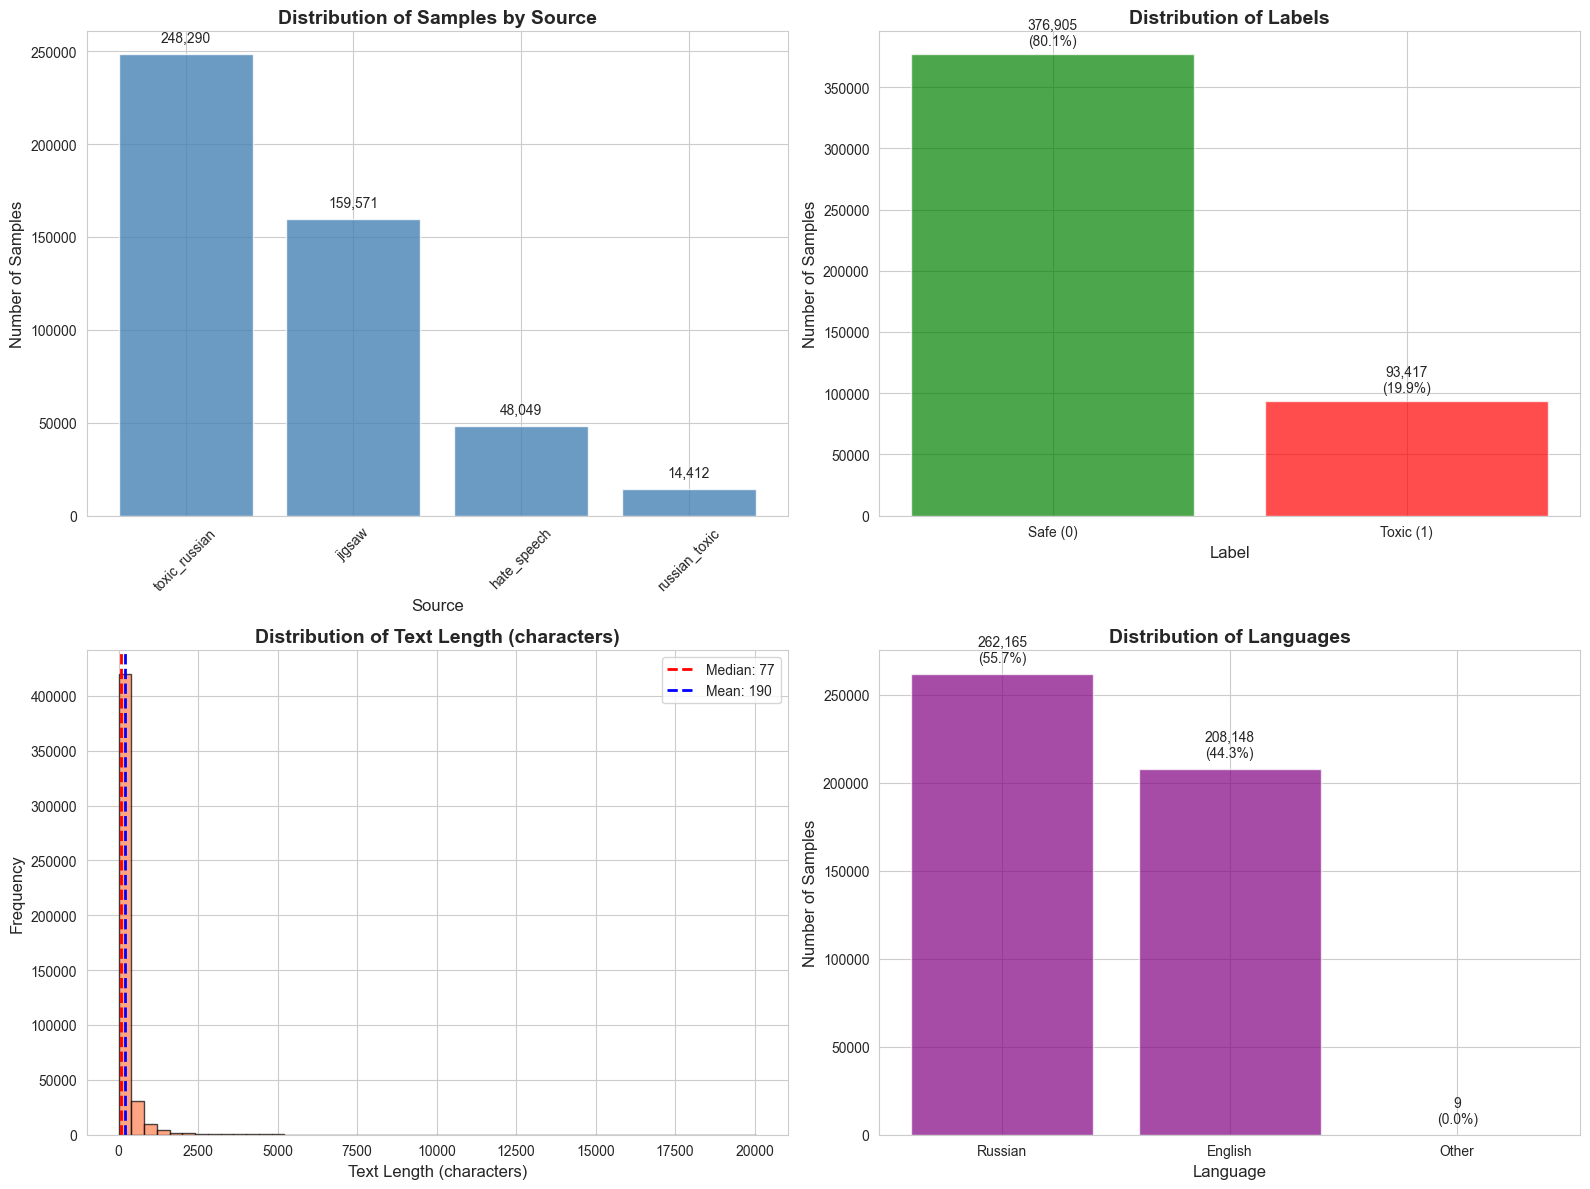


Text Length Statistics:
  Mean: 190.35 characters
  Median: 77 characters
  Min: 1 characters
  Max: 20030 characters

Language Distribution:
language
Russian    262165
English    208148
Other           9
Name: count, dtype: int64


In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (15, 10)

# Create subplots
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Distribution by source
source_counts = df_all['source'].value_counts()
axes[0, 0].bar(source_counts.index, source_counts.values, color='steelblue', alpha=0.8)
axes[0, 0].set_title('Distribution of Samples by Source', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Source', fontsize=12)
axes[0, 0].set_ylabel('Number of Samples', fontsize=12)
axes[0, 0].tick_params(axis='x', rotation=45)
for i, v in enumerate(source_counts.values):
    axes[0, 0].text(i, v + 5000, f'{v:,}', ha='center', va='bottom', fontsize=10)

# 2. Distribution of labels (0 vs 1)
label_counts = df_all['y'].value_counts().sort_index()
label_names = ['Safe (0)', 'Toxic (1)']
colors = ['green', 'red']
axes[0, 1].bar(label_names, label_counts.values, color=colors, alpha=0.7)
axes[0, 1].set_title('Distribution of Labels', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Label', fontsize=12)
axes[0, 1].set_ylabel('Number of Samples', fontsize=12)
for i, v in enumerate(label_counts.values):
    percentage = v / len(df_all) * 100
    axes[0, 1].text(i, v + 5000, f'{v:,}\n({percentage:.1f}%)', ha='center', va='bottom', fontsize=10)

# 3. Distribution of text length
df_all['text_length'] = df_all['text'].str.len()
axes[1, 0].hist(df_all['text_length'], bins=50, color='coral', alpha=0.7, edgecolor='black')
axes[1, 0].set_title('Distribution of Text Length (characters)', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Text Length (characters)', fontsize=12)
axes[1, 0].set_ylabel('Frequency', fontsize=12)
axes[1, 0].axvline(df_all['text_length'].median(), color='red', linestyle='--', linewidth=2, label=f'Median: {df_all["text_length"].median():.0f}')
axes[1, 0].axvline(df_all['text_length'].mean(), color='blue', linestyle='--', linewidth=2, label=f'Mean: {df_all["text_length"].mean():.0f}')
axes[1, 0].legend()

# 4. Distribution of languages
def detect_language(text):
    if not isinstance(text, str):
        return 'unknown'
    # Simple heuristic: check for cyrillic characters
    cyrillic_count = sum(1 for char in text if '\u0400' <= char <= '\u04FF')
    latin_count = sum(1 for char in text if 'a' <= char.lower() <= 'z')
    
    if cyrillic_count > latin_count:
        return 'Russian'
    elif latin_count > 0:
        return 'English'
    else:
        return 'Other'

df_all['language'] = df_all['text'].apply(detect_language)
lang_counts = df_all['language'].value_counts()
axes[1, 1].bar(lang_counts.index, lang_counts.values, color='purple', alpha=0.7)
axes[1, 1].set_title('Distribution of Languages', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Language', fontsize=12)
axes[1, 1].set_ylabel('Number of Samples', fontsize=12)
for i, v in enumerate(lang_counts.values):
    percentage = v / len(df_all) * 100
    axes[1, 1].text(i, v + 5000, f'{v:,}\n({percentage:.1f}%)', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

# Print summary statistics
print(f"\nText Length Statistics:")
print(f"  Mean: {df_all['text_length'].mean():.2f} characters")
print(f"  Median: {df_all['text_length'].median():.0f} characters")
print(f"  Min: {df_all['text_length'].min()} characters")
print(f"  Max: {df_all['text_length'].max()} characters")

print(f"\nLanguage Distribution:")
print(df_all['language'].value_counts())

## 5. Save Combined Dataset

In [10]:
# Remove temporary columns used for analysis
df_save = df_all[['source', 'text', 'y']].copy()

# Save combined dataset
output_path = '/Users/ar.babkin/Desktop/Visual_Studio_IDE/GenAI-Safety-Fliter/data/train_dataset.csv'
df_save.to_csv(output_path, index=False)
print(f"Saved combined dataset to {output_path}")

Saved combined dataset to /Users/ar.babkin/Desktop/Visual_Studio_IDE/GenAI-Safety-Fliter/data/train_dataset.csv
